In [229]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


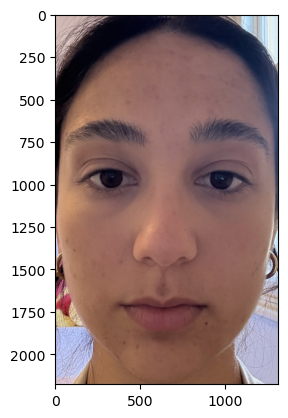

In [230]:
# Load image
img = cv2.imread('ameline_test_faces/test.jpg', cv2.IMREAD_COLOR_RGB)
plt.imshow(img)


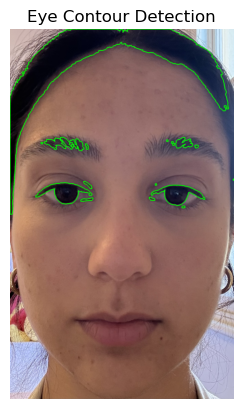

In [231]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

_, mask = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

# Restrict to upper half of face (optional)
h, w = mask.shape
mask[int(h/2):, :] = 0

# Morphological clean up
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=4)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), thickness=3)

# for c in contours:
#     x, y, w, h = cv2.boundingRect(c)
#     # Filter by size (optional)
#     if 10 < w < 100 and 10 < h < 50:
#         # Draw bounding rectangle in green
#         cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         # Draw the contour itself in red
#         cv2.drawContours(img_contours, [c], -1, (0, 0, 255), 1)



plt.imshow(img_contours)
plt.axis('off')
plt.title('Eye Contour Detection')
plt.show()



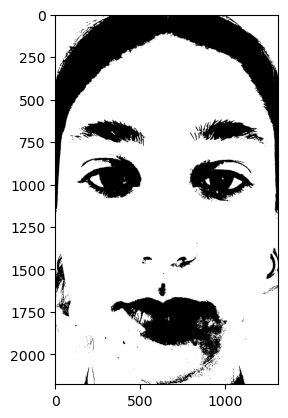

In [232]:
# Contour detection 
img = cv2.imread('ameline_test_faces/test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh_val_used, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh, 'gray') # show the thresholded image


Number of contours found: 68


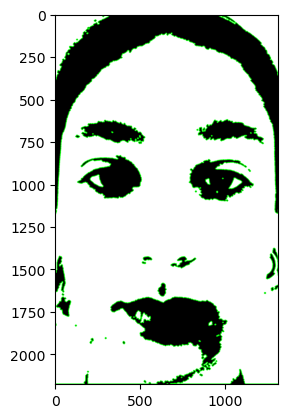

In [233]:
# Contour finding
# We can remove these by performing some morphological operations (opening and closing) on the binary image first
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
thresh_coins2 = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh_coins2 = cv2.morphologyEx(thresh_coins2, cv2.MORPH_CLOSE, kernel)

# Calculate contours in the binary image (re-calculated on cleaned-up binary image)
contours, hierarchy = cv2.findContours(thresh_coins2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# draw these contours to the image and display the number of extracted contours
coins_temp = thresh_coins2.copy()
coins_temp = cv2.cvtColor(coins_temp, cv2.COLOR_GRAY2RGB)
cv2.drawContours(coins_temp, contours, -1, (0,255,0), 3) # draw using bright green

plt.imshow(coins_temp, 'gray') # show the thresholded image

#aspect ratio, total area 


print("Number of contours found: %d"%(len(contours)))

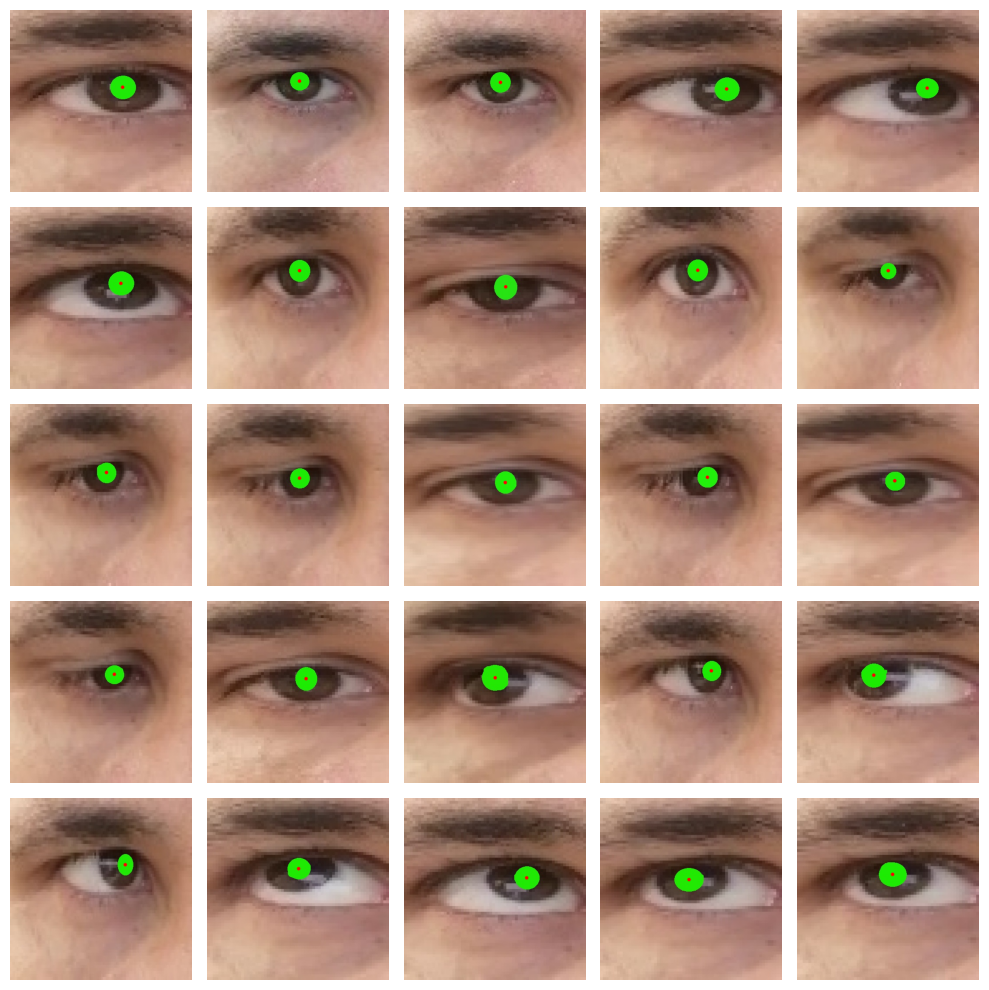

x_centroid: [257, 211, 220, 289, 297, 253, 211, 232, 223, 208, 220, 211, 231, 245, 223, 238, 226, 208, 254, 175, 263, 209, 280, 203, 218]
y_centroid: [176, 162, 165, 180, 178, 174, 145, 182, 144, 145, 156, 169, 179, 167, 175, 167, 177, 175, 159, 169, 152, 161, 182, 186, 174]


In [234]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

folder_path = "eye_truth"
image_files = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))  # sorted for consistency

x_centroid = []
y_centroid = []
annotated_images = []

for file in image_files:
    img = cv2.imread(file)
    if img is None:
        continue

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define green color range (for your ground-truth circles)
    lower_green = np.array([40, 100, 100])
    upper_green = np.array([80, 255, 255])

    # Create binary mask for green areas
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cx, cy = None, None
    if contours:
        biggest = max(contours, key=cv2.contourArea)
        M = cv2.moments(biggest)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            x_centroid.append(cx)
            y_centroid.append(cy)
        else:
            x_centroid.append(None)
            y_centroid.append(None)
    else:
        x_centroid.append(None)
        y_centroid.append(None)

    # Annotate image
    annotated = img.copy()
    if cx is not None and cy is not None:
        cv2.circle(annotated, (cx, cy), 4, (0, 0, 255), -1)
    annotated_images.append(annotated)


# --- Display annotated images as grid ---
plt.figure(figsize=(10, 10))
for i in range(min(len(annotated_images), 25)):
    img_rgb = cv2.cvtColor(annotated_images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis("off")

plt.tight_layout()
plt.show()

print("x_centroid:", x_centroid)
print("y_centroid:", y_centroid)


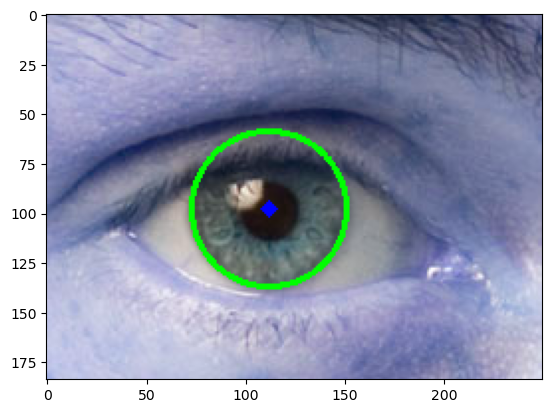

In [235]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('ameline_test_faces/eye.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocess — blur helps reduce noise and improves circle detection
gray = cv2.medianBlur(gray, 5)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1,            # Inverse ratio of accumulator resolution
    minDist=gray.shape[0]/8,  # Minimum distance between circle centers
    param1=100,      # Higher threshold for Canny edge detector
    param2=30,       # Accumulator threshold for circle detection (smaller -> more circles)
    minRadius=20,    # Minimum possible circle radius
    maxRadius=80     # Maximum possible circle radius
)

# If circles are found, draw them
if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)  # outer circle
        cv2.circle(img, (x, y), 2, (0, 0, 255), 3)  # center point

# Show result
plt.imshow(img)

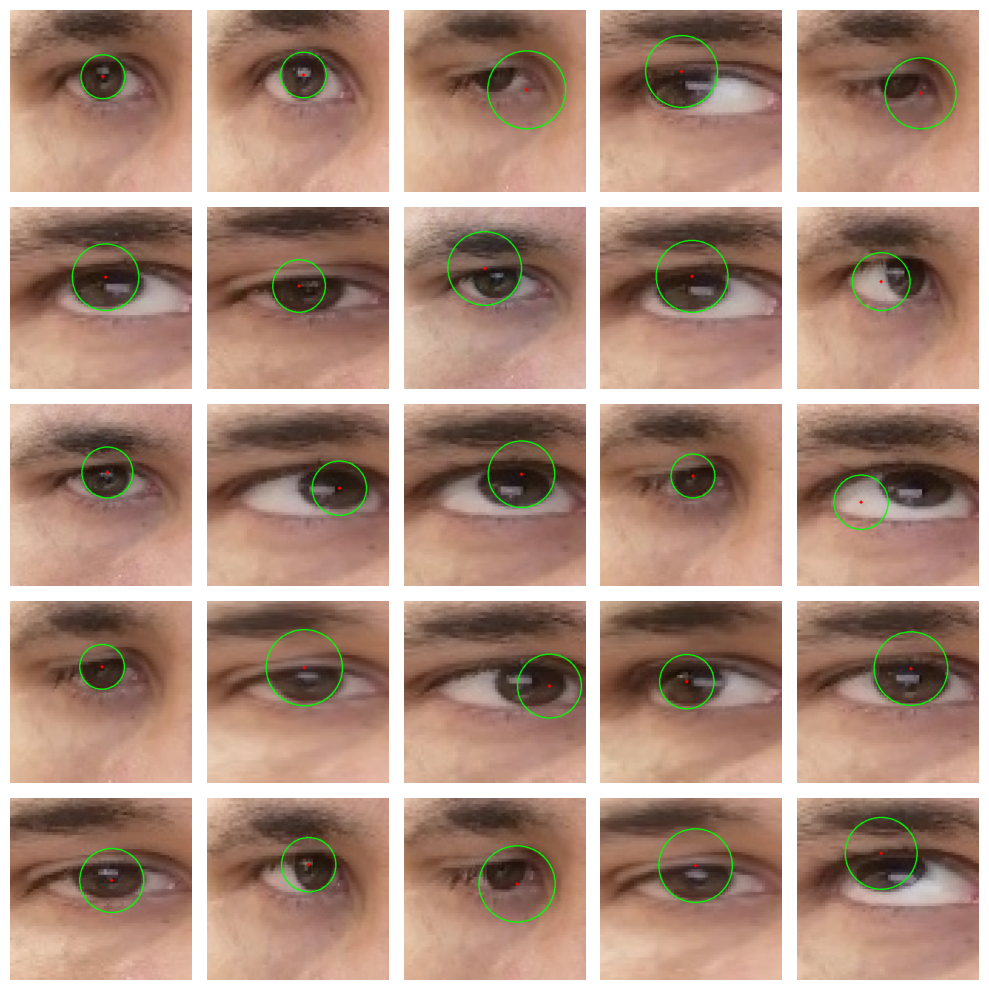

x_centroid: [212, 220, 280, 186, 282, 218, 210, 184, 210, 192, 222, 302, 268, 212, 146, 210, 222, 332, 198, 260, 232, 232, 258, 218, 192]
y_centroid: [152, 148, 182, 140, 190, 160, 180, 140, 158, 170, 156, 192, 160, 164, 224, 150, 152, 194, 184, 154, 188, 152, 196, 154, 126]


In [236]:
import cv2
import os
import glob

x_centroid_d1 = []
y_centroid_d1 = []

####################################################### FINDING CENTROIDS ##################################################
# Path to folder containing images
folder_path = "eye_dataset"

# Get all image file paths (supports jpg, png, etc.)
image_files = glob.glob(os.path.join(folder_path, "*.jpg")) 
            
# Load in all 25 images 
images = []
for file in image_files:
    img = cv2.imread(file)
    if img is not None:
        images.append(img)


for img in images: 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Preprocess — blur helps reduce noise and improves circle detection
    gray = cv2.medianBlur(gray, 5)
    # gray = cv2.GaussianBlur(gray, (5, 7), 2)
    gray = cv2.equalizeHist(gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    gray = clahe.apply(gray)

    kernel = np.ones((3,3), np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=1)  # remove small bright noise
    gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1) # fill small dark holes


    _, mask = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY_INV)
    gray = cv2.bitwise_and(gray, gray, mask=mask)


    

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1,            # Inverse ratio of accumulator resolution
        minDist=gray.shape[0],  # Minimum distance between circle centers
        param1=100,      # Higher threshold for Canny edge detector
        param2=23,       # Accumulator threshold for circle detection (smaller -> more circles)
        minRadius=40,    # Minimum possible circle radius
        maxRadius=90     # Maximum possible circle radius
    )

    # If circles are found, draw them
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            cv2.circle(img, (x, y), r, (0, 255, 0), 2)  # outer circle
            cv2.circle(img, (x, y), 2, (0, 0, 255), 3)  # centroid
            x_centroid_d1.append(x)
            y_centroid_d1.append(y)


plt.figure(figsize=(10, 10)) 

for i in range(25):
    img = images[i]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("x_centroid:", x_centroid_d1)
print("y_centroid:", y_centroid_d1)


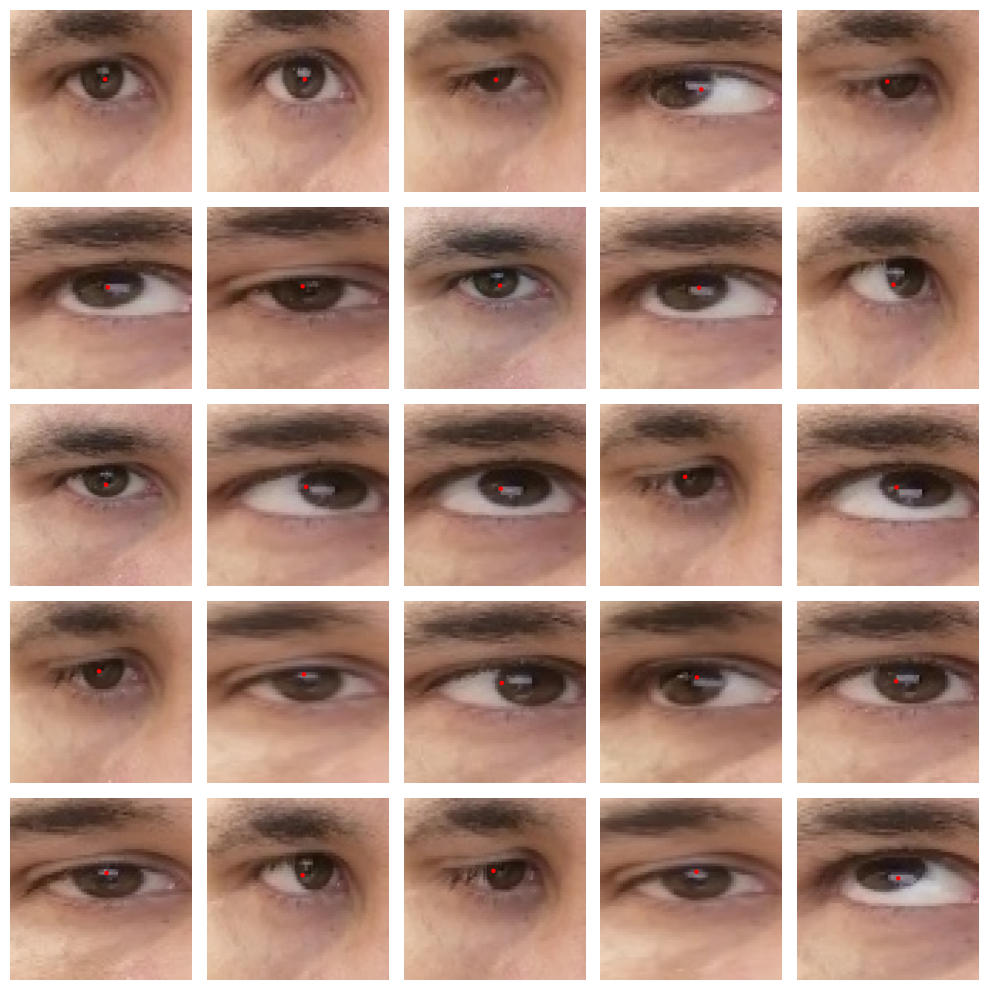

x_centroid: [217, 223, 210, 231, 206, 223, 218, 219, 226, 220, 219, 226, 221, 194, 227, 203, 221, 223, 221, 226, 220, 218, 204, 220, 231]
y_centroid: [158, 158, 159, 181, 163, 183, 181, 179, 184, 177, 184, 189, 193, 166, 190, 160, 167, 187, 174, 183, 171, 176, 166, 168, 183]


In [237]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

x_centroid_d2 = []
y_centroid_d2 = []

folder_path = "eye_dataset"
image_files = glob.glob(os.path.join(folder_path, "*.jpg"))

images = []
for file in image_files:
    img = cv2.imread(file)
    if img is not None:
        images.append(img)

for img in images:
    # Invert the image 
    inverted = cv2.bitwise_not(img)

    

    ############################################### EYE CORNER DETECTION ################################################
    # rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # # Optional blur (not required for white mask, but keeping your flow)
    # blur = cv2.GaussianBlur(rgb, (3, 3), 0)

    # edges = cv2.Canny(blur, 40, 110)


    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    # closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # dilated = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel)

    # edge_contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # min_area = 0  # tweak this value based on your image scale

    # filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # cv2.drawContours(img, edge_contours, -1, (0, 255, 255), 1)



   



    ################################################# PUPIL DETECTION ###################################################
    # Convert to grayscale
    gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    gray = cv2.medianBlur(gray, 5)




    # Apply erosion transform
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=1)
    # eroded = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # Binary threshold 
    _, thresh = cv2.threshold(eroded, 100, 255, cv2.THRESH_BINARY)

    # Find contours 
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find biggest contour by area
        biggest = max(contours, key=cv2.contourArea)

        # Get moments for center
        M = cv2.moments(biggest)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Get bounding rect for height
        x, y, w, h = cv2.boundingRect(biggest)

        # Draw circle on original image
        radius = max(w, h) // 2
        center = (cX, cY)
        # cv2.circle(img, center, radius, (0, 255, 0), 2)
        cv2.circle(img, center, 5, (0, 0, 255), -1)  # center point
        x_centroid_d2.append(cX)
        y_centroid_d2.append(cY)


plt.figure(figsize=(10, 10)) 
for i in range(min(len(images), 25)):
    img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("x_centroid:", x_centroid_d2)
print("y_centroid:", y_centroid_d2)




In [238]:
# import cv2
# import glob
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# x_centroid_d2 = []
# y_centroid_d2 = []

# folder_path = "eye_dataset"
# image_files = glob.glob(os.path.join(folder_path, "*.jpg"))

# images = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)

# for img in images:
#     # Invert the image 
#     inverted = cv2.bitwise_not(img)

#     ################################################# PUPIL DETECTION ###################################################
#     # Convert to grayscale
#     gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)

#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     gray = clahe.apply(gray)
    
#     gray = cv2.medianBlur(gray, 5)



#     # Apply erosion transform
#     kernel = np.ones((3,3), np.uint8)
#     eroded = cv2.erode(gray, kernel, iterations=1)
#     # eroded = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

#     # Binary threshold 
#     _, thresh = cv2.threshold(eroded, 200, 255, cv2.THRESH_BINARY)

#     # Find contours 
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if contours:
#         # Find biggest contour by area
#         biggest = max(contours, key=cv2.contourArea)

#         # Get moments for center
#         M = cv2.moments(biggest)
#         if M["m00"] != 0:
#             cX = int(M["m10"] / M["m00"])
#             cY = int(M["m01"] / M["m00"])
#         else:
#             cX, cY = 0, 0

#         # Get bounding rect for height
#         x, y, w, h = cv2.boundingRect(biggest)

#         # Draw circle on original image
#         radius = max(w, h) // 2
#         center = (cX, cY)
#         cv2.circle(img, center, radius, (0, 255, 0), 2)
#         cv2.circle(img, center, 5, (0, 0, 255), -1)  # center point
#         x_centroid_d2.append(cX)
#         y_centroid_d2.append(cY)


# plt.figure(figsize=(10, 10)) 
# for i in range(min(len(images), 25)):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     plt.subplot(5, 5, i+1)
#     plt.imshow(img_rgb)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# print("x_centroid:", x_centroid_d2)
# print("y_centroid:", y_centroid_d2)




In [239]:
# # Ameline test new code 

# import cv2
# import glob
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# # Lists for centroids
# x_centroid_d1 = []
# y_centroid_d1 = []

# # Load images
# folder_path = "eye_dataset"
# image_files = glob.glob(os.path.join(folder_path, "*.jpg"))

# images = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)

# # Process each image
# for img in images:
#     # Invert to emphasize pupil
#     inverted = cv2.bitwise_not(img)
#     gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)

#     # Enhance contrast
#     clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8,8))
#     enhanced = clahe.apply(gray)

#     # Smooth noise
#     blur = cv2.GaussianBlur(enhanced, (9, 9), 0)

#     # Erode to reduce reflections
#     kernel = np.ones((3, 3), np.uint8)
#     eroded = cv2.erode(blur, kernel, iterations=1)

#     # Additional blur to smooth edges
#     blur2 = cv2.GaussianBlur(eroded, (15, 15), 0)

#     # Compute Sobel gradients in X and Y directions
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

#     # Compute gradient magnitude
#     magnitude = cv2.magnitude(sobelx, sobely)

#     # Convert to 8-bit image and normalize
#     edges = cv2.convertScaleAbs(magnitude)
#     edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX)

#     # Threshold to get binary edge map
#     _, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

#     # Find contours from Sobel edges
#     contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Draw contours
#     cv2.drawContours(img, contours, -1, (0, 255, 0), 2)


# # Display all processed images
# plt.figure(figsize=(10, 10))
# for i in range(min(25, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(img_rgb)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# print("x_centroid:", x_centroid_d1)
# print("y_centroid:", y_centroid_d1)


In [240]:

# Example: assuming you have these lists
# x_centroid, y_centroid are the ground truth
# x_centroid_d1, y_centroid_d1 are the detected/tested points

# Convert to numpy arrays for vectorized operations
x_truth = np.array(x_centroid)
y_truth = np.array(y_centroid)
x_test_d1 = np.array(x_centroid_d1)
y_test_d1 = np.array(y_centroid_d1)

# Compute RMSE for Method 1
rmse_d1 = np.sqrt(np.mean((x_truth - x_test_d1)**2 + (y_truth - y_test_d1)**2))

print(f"RMSE (Method 1): {rmse_d1:.4f}")

# Method 2
x_test_d2 = np.array(x_centroid_d2)
y_test_d2 = np.array(y_centroid_d2)

rmse_d2 = np.sqrt(np.mean((x_truth - x_test_d2)**2 + (y_truth - y_test_d2)**2))
print(f"RMSE (Method 2): {rmse_d2:.4f}")


RMSE (Method 1): 57.8674
RMSE (Method 2): 39.6035


/tmp/ipykernel_3990/486491071.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


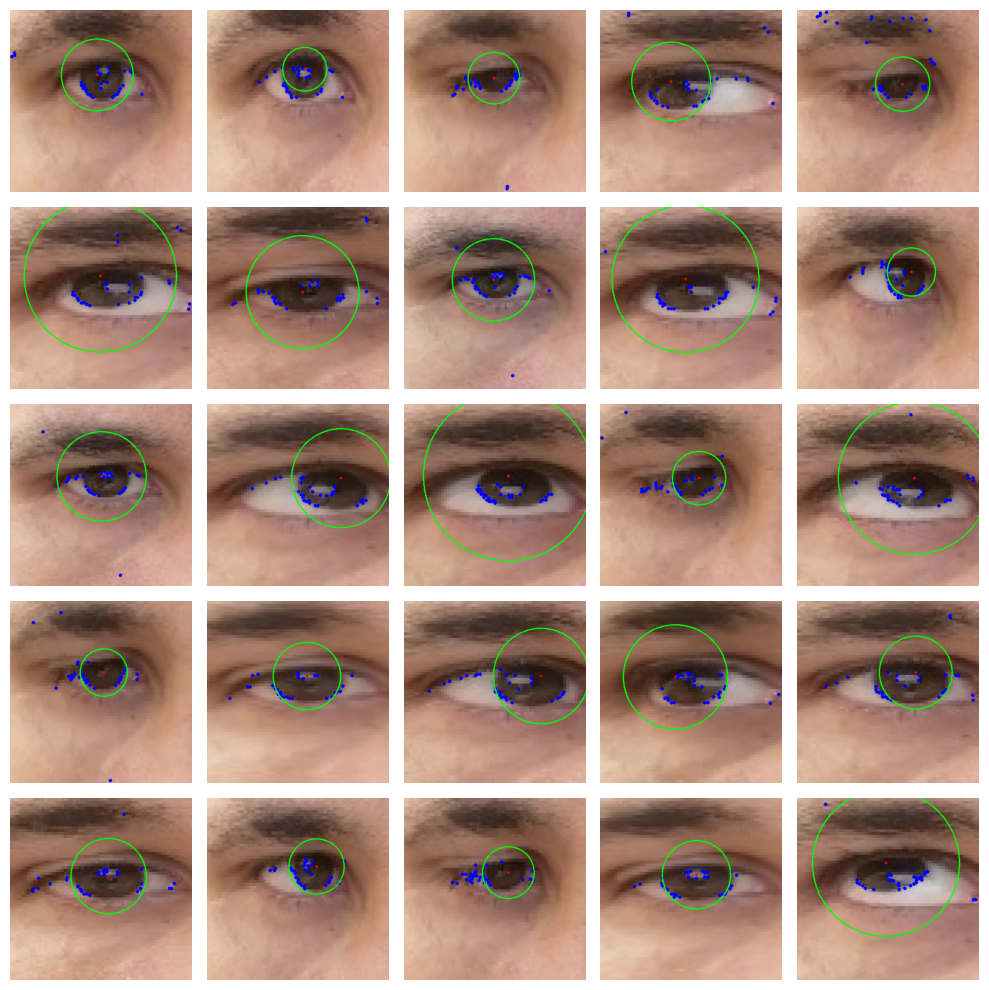

In [241]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

folder_path = "eye_dataset"
image_files = glob.glob(os.path.join(folder_path, "*.jpg"))

images = []
for file in image_files:
    img = cv2.imread(file)
    if img is not None:
        images.append(img)

for img in images:
    # Invert the image 
    inverted = cv2.bitwise_not(img)

    

    ############################################### EYE CORNER DETECTION ################################################

    gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)

    corners = cv2.goodFeaturesToTrack(gray, maxCorners=30, qualityLevel=0.01, minDistance=5)
    if corners is not None:
        corners = np.int0(corners)
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(img, (x, y), 4, (255, 0, 0), -1)  # Draw corners in blue

    # gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(gray, (7, 7), 0)
    # gray_float = np.float32(blur)

    # # Harris corner detection
    # corners = cv2.cornerHarris(src=gray_float, blockSize=2, ksize=3, k=0.04)

    # # Dilate to enhance corner regions (optional, helps visualization)
    # corners_dilated = cv2.dilate(corners, None)

    # # Threshold for an optimal value to mark the corners
    # threshold = 0.01 * corners_dilated.max()
    # corner_coords = np.argwhere(corners_dilated > threshold)

    # # Draw the corners
    # for y, x in corner_coords:
    #     cv2.circle(img, (x, y), 3, (255, 0, 0), -1)  # blue dots



   



    ################################################# PUPIL DETECTION ###################################################
    # Convert to grayscale
    gray = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)


    # Apply erosion transform
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=1)
    # eroded = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # Binary threshold 
    _, thresh = cv2.threshold(eroded, 200, 255, cv2.THRESH_BINARY)

    # Find contours 
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find biggest contour by area
        biggest = max(contours, key=cv2.contourArea)

        # Get moments for center
        M = cv2.moments(biggest)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Get bounding rect for height
        x, y, w, h = cv2.boundingRect(biggest)

        # Draw circle on original image
        radius = max(w, h) // 2
        center = (cX, cY)
        cv2.circle(img, center, radius, (0, 255, 0), 2)
        cv2.circle(img, center, 3, (0, 0, 255), -1)  # center point


plt.figure(figsize=(10, 10)) 
for i in range(min(len(images), 25)):
    img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.tight_layout()
plt.show()
